In [1]:
import pandas as pd
import numpy as np
import mikeio
import matplotlib.pyplot as plt
from random import random

## Test data

Model results

model result equidistant at lower res than observations, with nan and with gap

In [2]:
fn = '../tests/testdata/SW/ts_storm_4.dfs0'
mr1 = mikeio.read(fn, items=0).to_dataframe()
mr1 = mr1.resample('2H').nearest()
mr1 = mr1.rename(columns={mr1.columns[0]:'mr1'})
mr2 = mr1.copy().rename(columns=dict(mr1='mr2'))-1 # for plotting...
mr2.loc["2017-10-28"] = np.nan
mr3 = mr2.copy().dropna().rename(columns=dict(mr2='mr3'))-1

Observation

With random time steps and with gaps

In [3]:
fn = '../tests/testdata/SW/eur_Hm0.dfs0'
obs = mikeio.read(fn, items=0).to_dataframe().rename(columns=dict(Hm0='obs'))+1
dt = pd.Timedelta(1800, unit='s')
obs.index = [t+dt*(random()-0.5) for t in obs.index]
obs.index = obs.index.round('S')
obs = obs.sample(frac=0.7).sort_index()

Plot test data

Text(0.5, 1.0, 'Test data')

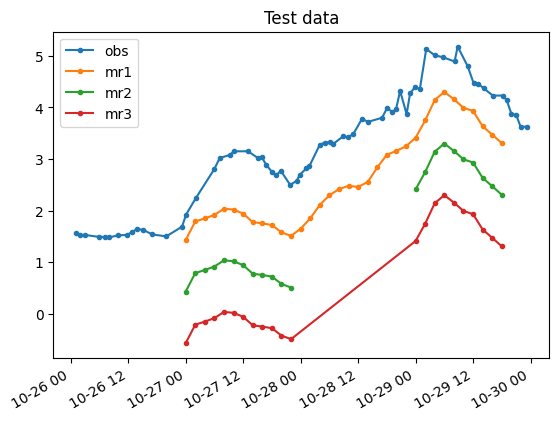

In [4]:
fig, ax = plt.subplots(1,1)
obs.plot(ax=ax, marker='.')
mr1.plot(ax=ax, marker='.')
mr2.plot(ax=ax, marker='.')
mr3.plot(ax=ax, marker='.')
plt.title('Test data')

## v1: no model gap handling

fmskill previous to max model gap fix

--> Not doing the job as we know

In [5]:
def interp_df(df, new_time):
    new_df = (
        df.reindex(df.index.union(new_time))
        .interpolate(method="time", limit_area="inside")
        .reindex(new_time)
        )
    return new_df

In [6]:
c = (
    obs.join(interp_df(mr1, obs.index))
    .join(interp_df(mr2, obs.index))
    .join(interp_df(mr3, obs.index))
)
c.loc["2017-10-28"].head()

,obs,mr1,mr2,mr3
2017-10-28 01:12:59,2.82,1.770270,0.744828,-0.255172
2017-10-28 01:48:47,2.86,1.829592,0.788477,-0.211523
2017-10-28 04:01:18,3.28,2.113314,0.950048,-0.049952
2017-10-28 05:05:15,3.32,2.212593,1.028019,0.028019
2017-10-28 06:13:59,3.33,2.311441,1.111822,0.111822


<AxesSubplot: title={'center': 'No model gap handling'}>

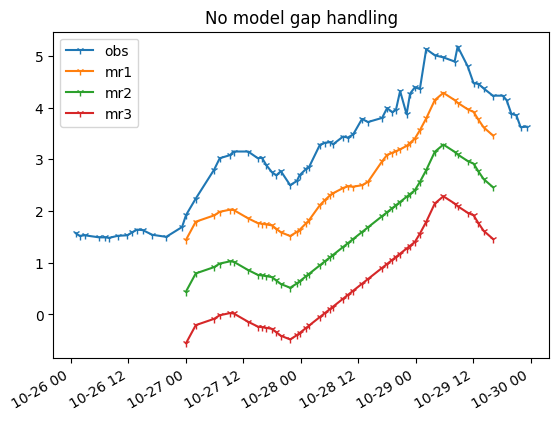

In [7]:
c.plot(marker='1', title='No model gap handling')

In [8]:
c.count()

obs    66
mr1    46
mr2    46
mr3    46
dtype: int64

### v2: pandas interpolation limit

Current suggestion with limit, probably sufficient for most use cases. 

--> But how to robust choose an int limit for a non-equidistant query time vector of the obs?

In [9]:
import statistics as stats
def mode_of_timestep(time):
    return pd.Timedelta(stats.mode(np.diff(time)))

In [10]:
def get_limit(time, max_timedelta):
    return int(np.ceil(max_timedelta/mode_of_timestep(time))) # not very robust...?

In [11]:
def interp_df_v2(df, new_time, max_model_gap):
    limit = get_limit(new_time, max_model_gap)
    new_df = (
        df.reindex(df.index.union(new_time))
        .interpolate(method="time", limit_area="inside", limit=limit)
        .reindex(new_time)
        )
    return new_df

Max model gap as mode of time step (could be default...?)

In [12]:
max_model_gap1 = mode_of_timestep(mr1.index)
max_model_gap2 = mode_of_timestep(mr2.index)
max_model_gap3 = mode_of_timestep(mr3.index)
max_model_gap1, max_model_gap2, max_model_gap3

(Timedelta('0 days 02:00:00'),
 Timedelta('0 days 02:00:00'),
 Timedelta('0 days 02:00:00'))

In [13]:
c2 = (
    obs.join(interp_df_v2(mr1, obs.index, max_model_gap1))
    .join(interp_df_v2(mr2, obs.index, max_model_gap2))
    .join(interp_df_v2(mr3, obs.index, max_model_gap3))
)
c2.loc["2017-10-28"].head()

,obs,mr1,mr2,mr3
2017-10-28 01:12:59,2.82,1.770270,NaN,-0.255172
2017-10-28 01:48:47,2.86,1.829592,NaN,NaN
2017-10-28 04:01:18,3.28,2.113314,NaN,NaN
2017-10-28 05:05:15,3.32,2.212593,NaN,NaN
2017-10-28 06:13:59,3.33,2.311441,NaN,NaN


mr3 with the actual gap is handled differently than mr2 with nan, although both have the same max gap.

In [14]:
c2.count()

obs    66
mr1    46
mr2    27
mr3    28
dtype: int64

<AxesSubplot: >

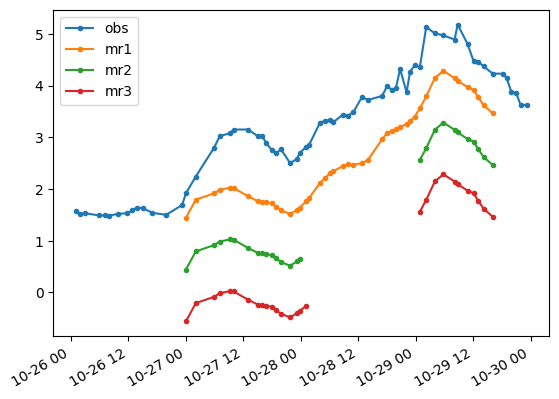

In [15]:
c2.plot(marker='.')

### v3: Manually identify valid obs timesteps

Work in progress...

## Misc

Btw, in this format observations can easily be maintained only where *all* models are available (to ensure the fair multi-model comparison).

<AxesSubplot: >

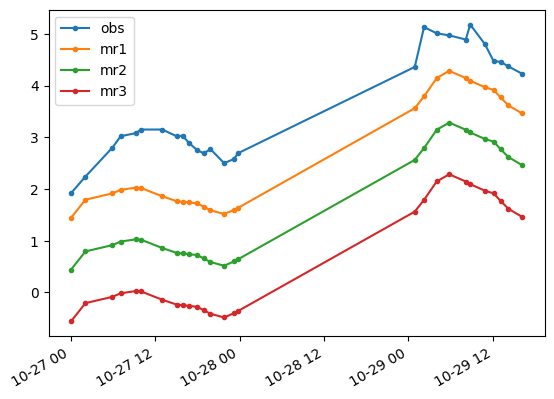

In [16]:
c2.dropna().plot(marker='.')